# DIGITAL EPIDEMIOLOGY

## Homework 1

### _Martino Ciaperoni_ , _Eleonora Grassucci_, _Tommaso Lanciano_

## Abstract

In 2014, McIver and Brownstein [[1]](#Reference) propose an effective novel method of estimating, in near-real time, the level of influenza-like ilness (ILI), in the United States, based on particular Wikipedia article views. In this study, a similar method is proposed, with reference to Italy. Specifically, the ILI rates provided by [__Influnet__](https://old.iss.it/site/RMI/influnet/pagine/rapportoInflunet.aspx), the flu surveillance program run by the Italian Health Protection Agency are regarded as ground truth. The goal is to predict such rates based on chosen italian Wikipedia user habits.
It is shown that, as for the US, also in Italy, it is possible to exploit Wikipedia page views, in order to obtain near-real time, high-quality predictions. While in [[1]](#Reference), only a Poisson regularized generalized linear regression model is used, here, several different models are fitted via cross-validation. In the first section, a simple graphical exploration of the "Influenza" Wikipedia article as well as the ground truth time series is reported. The second section deals with the choice of the keywords to be used as predictors at the model fitting stage. Finally, in the last section, the formal regression analysis is described.

#### Libraries

In order to reproduce the code in your machine, please be sure that the following packages are imported.

In [59]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib
import requests
from bs4 import BeautifulSoup
import re
import networkx as nx
from selenium import webdriver
import time
from functools import reduce
import os
from scipy.stats import pearsonr, spearmanr
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.linear_model import Lasso, Ridge,ElasticNet, BayesianRidge, Lars, LassoLars, LinearRegression, MultiTaskElasticNet, MultiTaskLasso, ridge_regression
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from IPython.display import display, HTML
import tabulate
from h2o.grid.grid_search import H2OGridSearch
import seaborn as sns
import operator

### How to run this notebook

This notebook can be run alongside the folder structure contained in this Github Repository: https://github.com/tlancian/DE_Homeworks

## Part 1

### Part 1.1

In this part, the aim is to collect data from the Italian Wikipedia "Influenza" page, so as to understand whether the click rate of this page, aggregated to week level, highly correlate with the ground truth.

In [2]:
## FUNCTIONS

def process_influnet(file):
    ''' Process the Influnet csv, returning a Pandas Dataframe with the useful informations'''
    df = pd.read_csv("data/influnet/"+file)
    df = df.iloc[2:,[0,4]] #Takes only rows and columns of interest
    df.columns=["Date","Incidence"] #Gives meaningful names to columns
    df = df.replace(to_replace=",", value=".", regex=True) #Replaces commas with dots
    df["Incidence"] = pd.to_numeric(df["Incidence"]) #Set Incidence variable as numerical
    return df

def get_wiki_data(words):
    '''Access to the Wikipedia tool and download the file needed for our analysis'''
    bs_url = "https://tools.wmflabs.org/pageviews/?project=it.wikipedia.org&platform=all-access&agent=user&range=all-time&pages="+"|".join(words)

    driver = webdriver.Chrome()

    driver.get(bs_url)
    
    time.sleep(10)

    first_click = driver.find_elements_by_tag_name("button")
    first_click[6].click()
    
    driver.find_element_by_class_name("download-csv").click()

def get_week_number(entire_date):
    '''Return the number of the week given a date'''
    return entire_date.date().isocalendar()[1]

def get_year(entire_date):
    '''Return the year given a date'''
    return entire_date.year

def get_year_influnet(date):
    '''Return the year given a date'''
    return int(date[:4])

def get_week_influnet(date):
    '''Return the number of the week given a date'''
    return int(date[5:])

def aggregate_data(df):
    '''Process Wikipedia Data, aggregating them at a weekly level'''    
    ### Aggregate at weekly level 

    # Convert date to datetime
    df["Date"] = pd.to_datetime(df["Date"], yearfirst=True)

    # Get week number and year
    df["Week"] = df["Date"].apply(get_week_number)
    df["Year"] = df["Date"].apply(get_year)

    ### Select only weeks of interest for our analysis

    # Group by week number and year
    df = df.groupby(["Year", "Week"]).sum()
    df = df.stack()

    weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

    # Merging Dataframes
    temp = []
    for k,v in weeks_of_interest.items():
        for elem in v:
            temp.append(df.loc[k,list(range(elem[0],elem[1]+1))])

    df = pd.concat(temp).unstack()
    
    return df

def add_gt(data):
    '''Add the Ground Truth Information to Wikipedia Data'''
    data["GT"] = ["0" for _ in range(flu_data.shape[0])]
    data = data.stack()
    for year in data.index.levels[0]:
        for week in data.index.levels[1]:
            try:
                data.loc[year,[week],"GT"] = match_data(year,week)
            except:
                pass
    data = data.unstack()
    return data

def match_data(year,week):
    '''Find the corresponding GT incidence value given a year and a week'''
    val = gt["Incidence"].loc[(gt["Year"] == year) & (gt["Week"] == week)]
    return float(val)

### Influnet Data

As a first step, we want to check the trend of the flu incidence according to Influnet data.
For this purpose, data released by Influnet via .pdf files, are processed with Tabula and saved in an accessible comma-separate values (csv) format.
Once got the csv files, we are able to process them and select just the information meaningful for our purposes.

In [3]:
# Load and process the data

files = os.listdir("data/influnet")
gt = pd.concat(map(process_influnet, files), axis=0, ignore_index=True)
gt["Year"] = gt["Date"].apply(get_year_influnet)
gt["Week"] = gt["Date"].apply(get_week_influnet)

Once obtained the files, the incidence trend is plotted.

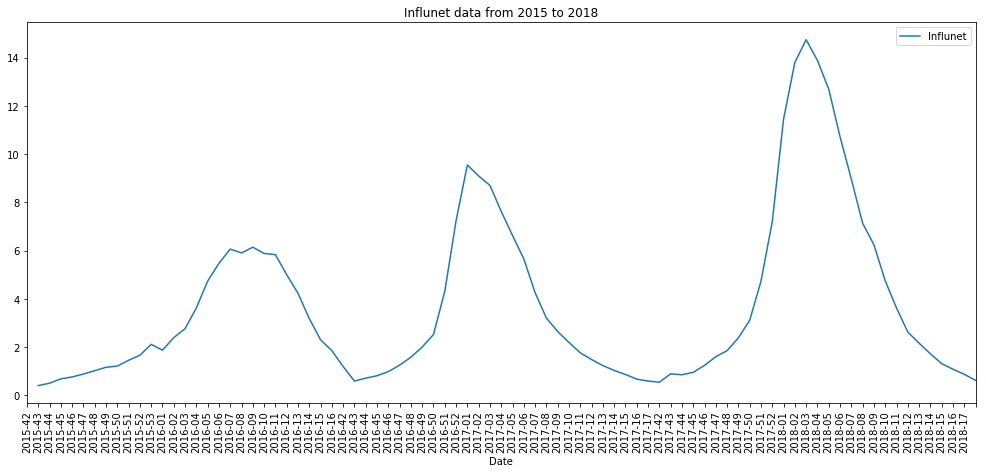

In [4]:
# Plot Influnet Data
gt.plot(x = "Date", y = "Incidence", label = "Influnet", figsize=(17,7))
plt.xticks(np.arange(-1, len(gt["Incidence"])), gt["Date"], rotation=90)
plt.title("Influnet data from 2015 to 2018")
plt.show()
plt.close()

### Wikipedia Data

Here, we want to gather data directly from Wikpedia. In particular, we exploit a tool released by Wikipedia itself, that allows to easily access data regarding the daily click rate for each WIkipedia page. 

First, let's collect the time series related to the Wikipedia "Influenza" page clicks. This line of code downloads the data we are looking for.

In [5]:
get_wiki_data(["Influenza"])

If we take a look to the data we have collected:

In [6]:
### Read the File
flu_data = pd.read_csv("data/flu_data.csv")
flu_data.head()

,Date,Influenza
0,2015-07-01,121.0
1,2015-07-02,94.0
2,2015-07-03,103.0
3,2015-07-04,76.0
4,2015-07-05,99.0


We can see that data are available at daily granularity. Thus, after we gather the data, we need to preprocess them, in order to get the same information we have in the ground truth.

Thus, our preprocessing includes:

- Aggregating the observations according to their week number.
- Selecting weeks that only appears in Influnet data.

In [7]:
flu_data = aggregate_data(flu_data)

Let us take a look again at the data:

In [8]:
flu_data.head()

Influenza
Year Week           
2015 42       1400.0
     43       1317.0
     44       1226.0
     45       1336.0
     46       1298.0

Now that they have the same structure as the ground truth, we can plot them.

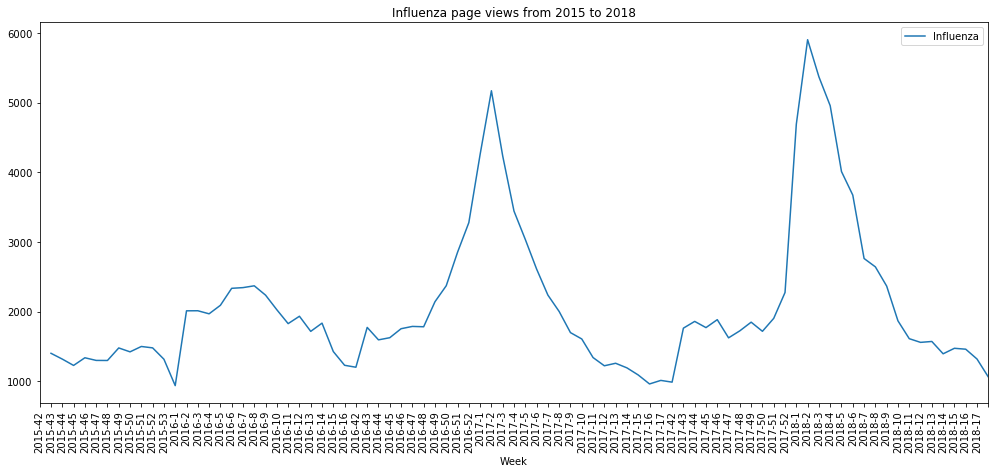

In [9]:
### Plot Wikipedia Data
flu_data.plot(y = "Influenza", label = "Influenza", figsize=(17,7))
plt.xticks(np.arange(-1, len(flu_data["Influenza"])), [str(x[0]) + "-" + str(x[1]) for x in flu_data.index], rotation=90)
plt.title("Influenza page views from 2015 to 2018")
plt.xlabel("Week")
plt.show()

Note that the x-axis tick labels indicate the year as well as the number of the week within the year. 

### Part 1.2

In [10]:
# Add the ground truth to the Influenza page Wikipedia page
flu_data = add_gt(flu_data)

It is considerably informative to compare the Influnet and Wikipedia "Influenza" page data. This can be accomplished graphically. 


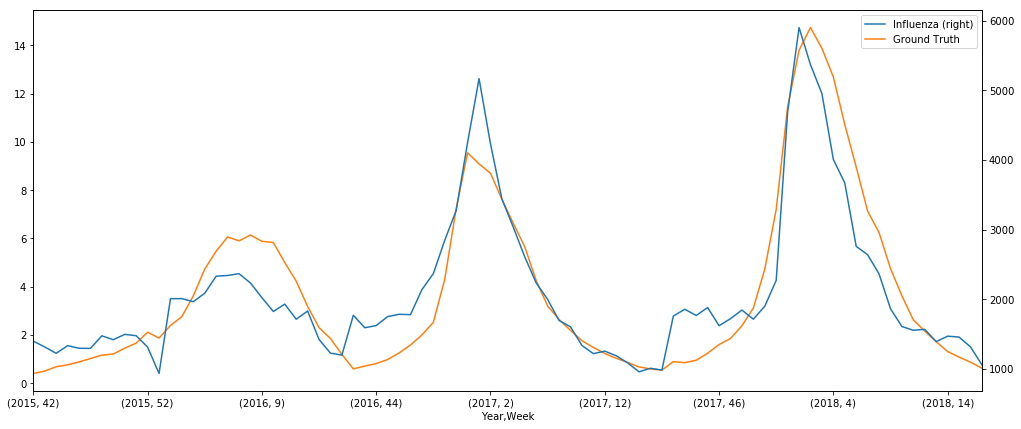

In [11]:
flu_data.Influenza.plot(secondary_y = True, label = "Influenza", figsize = (17,7), legend = True)
flu_data.GT.plot(label = "Ground Truth", legend = True)
plt.show()

It is worth noting that the Influnet and Wikipedia data overlayed in the plot above have different scales, as indicated in the left and right y-axis, respectively. 
Certainly, there exists a strong relationship between the two time series taken into account. 
More precisely, they both show high peaks in correspondence of every year January and February.
This observation is confirmed by the correlation measures computed below. 


In [12]:
print("Pearson Correlation: ", pearsonr(flu_data["Influenza"], flu_data["GT"])[0])
print("Spearman Correlation: ", spearmanr(flu_data["Influenza"], flu_data["GT"])[0])

Pearson Correlation:  0.9205795256419326
Spearman Correlation:  0.8380750852196114


Clearly, while the Pearson correlation coefficient captures the strength of linear relationship, the Spearman one measures the magnitude of any monotonic relationship.

## Part 2

### Part 2.1

In order to identify a set of keywords which might be valuable in order to predict the prevalence of influenza-like Illness, a proper approach involves exploring the portion of Wikipedia Web graph in a neighborhood of the "Influenza" page, in a breadth-first manner.

In [13]:
def get_wiki_links(url):
    
    '''This function returns the out links of a page given in url.
        We take:
        "/wiki", is the starting tag of wikipedia pages;
        We discard:
        "PMID", is the tag for counting the citations in a page;
        ":", is contained in all the link for Wikipedia "non" pages; 
        "secolo", is contained in all the link to a century page.
        '''
    page_response = requests.get(url)
    soup = BeautifulSoup(page_response.content, "html.parser")
    links = []
    for link in soup.find_all('a'):
        temp = str(link.get('href'))
        if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
            links.append("https://it.wikipedia.org" + temp)
    return links


def create_g(diz, url):
    
    '''This function creates the "Influenza" neighbours network.
        It takes in input the starting url and the dictionary got with the get_wiki_links func.
        It returns:
        - the Graph built;
        - the dictionaries with all the links.'''
    
    # set of all the links 
    visited = set()
    inverse_diz = dict() 
    allLinks = dict()
    G = nx.DiGraph() 
    G.add_node(0)
    diz[0] = url
    inverse_diz[url] = 0
    wiki_links = list(set(get_wiki_links(url)))
    allLinks[0] = wiki_links
    current_label = 0
    visited.add(url) 
    for i in range(len(wiki_links)):
        if wiki_links[i] not in  visited: 
            current_label += 1 
            G.add_node( current_label )
            diz[ current_label ] = wiki_links[i]
            inverse_diz[wiki_links[i]] = current_label
            G.add_edge(0 , current_label)
            visited.add(wiki_links[i]) 
          
    for i in range(len(wiki_links)):
        links_h1 = list(set(get_wiki_links(wiki_links[i])))
        precedent_label = inverse_diz[wiki_links[i]]
        allLinks[current_label] = links_h1
        for j in range(len(links_h1)):
            if links_h1[j] not in visited: 
                current_label += 1 
                G.add_node( current_label )
                inverse_diz[ links_h1[j] ] = current_label
                diz[ current_label ] = links_h1[j]
                G.add_edge( precedent_label , current_label )
                visited.add( links_h1[j] )

     #add links to already existing nodes 
     #to complete 
    for i in range(len(wiki_links)):
        for link in list(set(get_wiki_links(wiki_links[i]))):
            if link in visited and not G.has_edge( inverse_diz[ wiki_links[i] ], inverse_diz[link] ):
                G.add_edge(inverse_diz[ wiki_links[i] ], inverse_diz[link])
        
    return G, diz, inverse_diz, allLinks

def degree_ranking(G, n): 
    
    '''This functions returns the n pages associated with the higest degree.'''
    
    sortedDegree = sorted(dict(G.degree()).items(), key=lambda kv: kv[1],reverse = True)
    topWords = [diz[x[0]][30:] for x in sortedDegree[:n]]
    return topWords

Thus, here we parse the "Influenza" page $(I)$, and retrieve all the outlinks $(O)$ that contains. Once obtained $O$, we parse each page contained in this set and register only the outlinks that redirect to one of the pages of $O$, or to $I$.

Hence, the subgraph induced by the set of nodes $S=\{I,O\}$, is considered.

In [14]:
# Starting link: "Influenza" Wikipedia page

url = "https://it.wikipedia.org/wiki/Influenza"
diz = {}
start = time.time()
G, diz, inv_diz, allLinks = create_g(diz, url)
end = time.time()
G_sub = G.subgraph(list(G.neighbors(0)))

This is the time required for this operation.

In [15]:
print("Time required: "+ str(int(end-start)) + " seconds")

Time required: 213 seconds


In case nodes at a larger distance from the source, i.e. the "Infuenza" page are considered, this running time grows exponentially and the additional information is likely to be not drastically important.

Following the simple idea that, the more links a page has, the more probable is that you are going to visit that page and thus the more relevant the page is, we have considered the articles showing highest degree.

In particular, we take into account the top 20 pages with highest degree.

In [16]:
degree_ranking(G_sub,20)

['Influenza',
 'Influenzavirus_C',
 'Pagina_principale',
 'Asma',
 'Rinite',
 'Bronchite',
 'SARS',
 'Faringite',
 'Croup',
 'Sarcoidosi',
 'Broncopneumopatia_cronica_ostruttiva',
 'Sinusite',
 'Faringite_streptococcica',
 'Embolia_polmonare',
 'Bronchiolite',
 'Pneumotorace',
 'Versamento_pleurico',
 'Edema_polmonare',
 'Pleurite',
 'Tonsillite']

However, it is not appropriate to simply consider the words above. Indeed, epidemiology studies require integrating data analysis methods and subject matter knowledge. Indeed, the chosen words should be biologically meaningful.

Hence, we select from the list above, the words "Vomito" , "Bronchite", "Faringite", "Rinite", deemed to be relevant for our purposes. 

Nevertheless, it is easy to notice that the output of the link analysis procedure does not include common names for influence symptoms as well as drug names.
As a consequence, the aforementioned words are combined with other words, that comes directly from human expertise: "Tosse", "Raffreddore", "Febbre", "Ibruprofene", "Antipiretico", "Paracetamolo", "Polmonite", "Tonsillite" and "Flurbiprofene", which may be useful in our analysis.

Furthermore, the article "Pagina principale" is added, in order to account for general activity of normal usage of Wikipedia.

In [17]:
# Create the dataset
words = ["Vomito" , "Bronchite", "Faringite", "Rinite", "Paracetamolo","Tosse", "Raffreddore", "Febbre", "Ibuprofene", "Flurbiprofene", "Antipiretico", "Polmonite", "Tonsillite", "Pagina_principale", "Influenza"]

# Download data 
get_wiki_data(words[:10]) 
get_wiki_data(words[10:]) 

Here we load the resulting files coming from the Wikipedia tool, and we process them.

In [18]:
related_word_1 = pd.read_csv("data/related_word_data1.csv")
related_word_2 = pd.read_csv("data/related_word_data2.csv")

data = add_gt(pd.concat(map(aggregate_data, [related_word_1,related_word_2]), axis = 1))

### Part 2.2

To better understand which terms, among the selected ones, exhibit the largest correlation with the ground truth, the Pearson and the Spearman correlation coefficients are computed.

In [22]:
def corr_ranking(dataframe, words):
    
    '''Evaluate the Pearson and the Spearman correlation among the list of words and the GT
        Return the dictionary with the correlated words (both corr indices > 0.5) and their values.'''
    
    corr = {}
    for word in words:
        if pearsonr(dataframe["GT"], dataframe[word])[0]>0.5 and spearmanr(dataframe["GT"], dataframe[word])[0]>0.5:
            corr[word] = [pearsonr(dataframe["GT"], dataframe[word])[0], spearmanr(dataframe["GT"], dataframe[word])[0]]
    return sorted(corr.items(), key=operator.itemgetter(1), reverse=True)

The correlation among the selected words is graphically displayed in the following plot. 

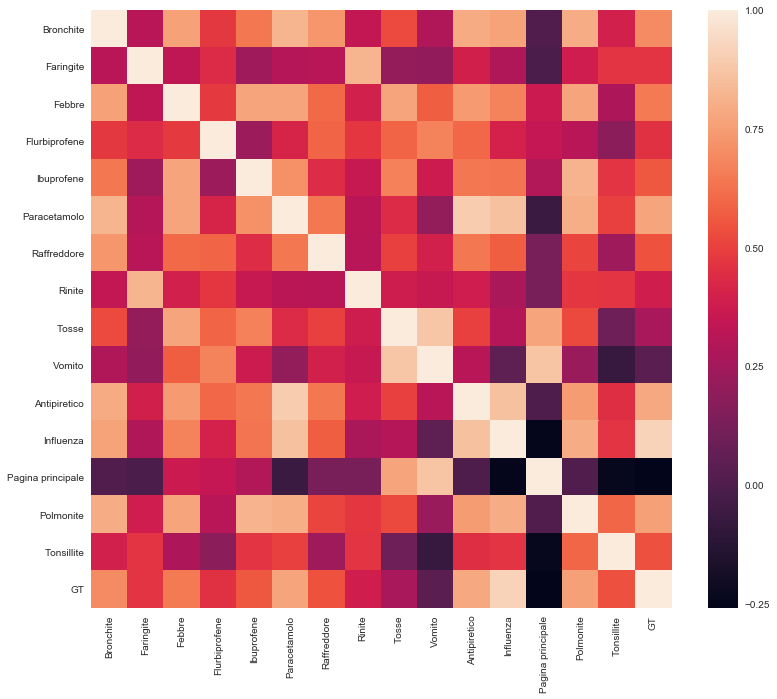

In [23]:
corr_plot = data.astype(float).corr()
sns.set(rc={'figure.figsize':(13,11)})
sns.heatmap(corr_plot, 
            xticklabels=data.astype(float).columns.values,
            yticklabels=data.astype(float).columns.values)
plt.show()

Clearly, there is a large correlation not only between the articles and the ground truth, but also among the terms. 
Moreover, below the articles associated with the largest correlation with the ground truth,  ranked in decreasing order of Pearson correlation coefficient, are shown. 

In [24]:
corr_words = corr_ranking(data, list(data.columns[:-1]))
print("The most correlated words are ([Pearson, Spearman]):\n")
for idx,word in enumerate(corr_words):
    print(idx+1,word[0], word[1])

The most correlated words are ([Pearson, Spearman]):

1 Influenza [0.9205795256419326, 0.8380750852196114]
2 Antipiretico [0.7795134437381952, 0.7692007836843181]
3 Paracetamolo [0.7705959640324906, 0.7774824715504173]
4 Polmonite [0.7546861680971892, 0.7946490496271684]
5 Bronchite [0.6974484494578517, 0.7954499434645579]
6 Febbre [0.6502940587680799, 0.672728101136027]
7 Raffreddore [0.5455445214930243, 0.575573158732888]
8 Tonsillite [0.5404503660498178, 0.5566535381536143]


As expected, we fail in identifying a better article than "Influenza" in terms of correlation with the Influnet ILI level.

Let us graphically explore the time series associated with all the words.

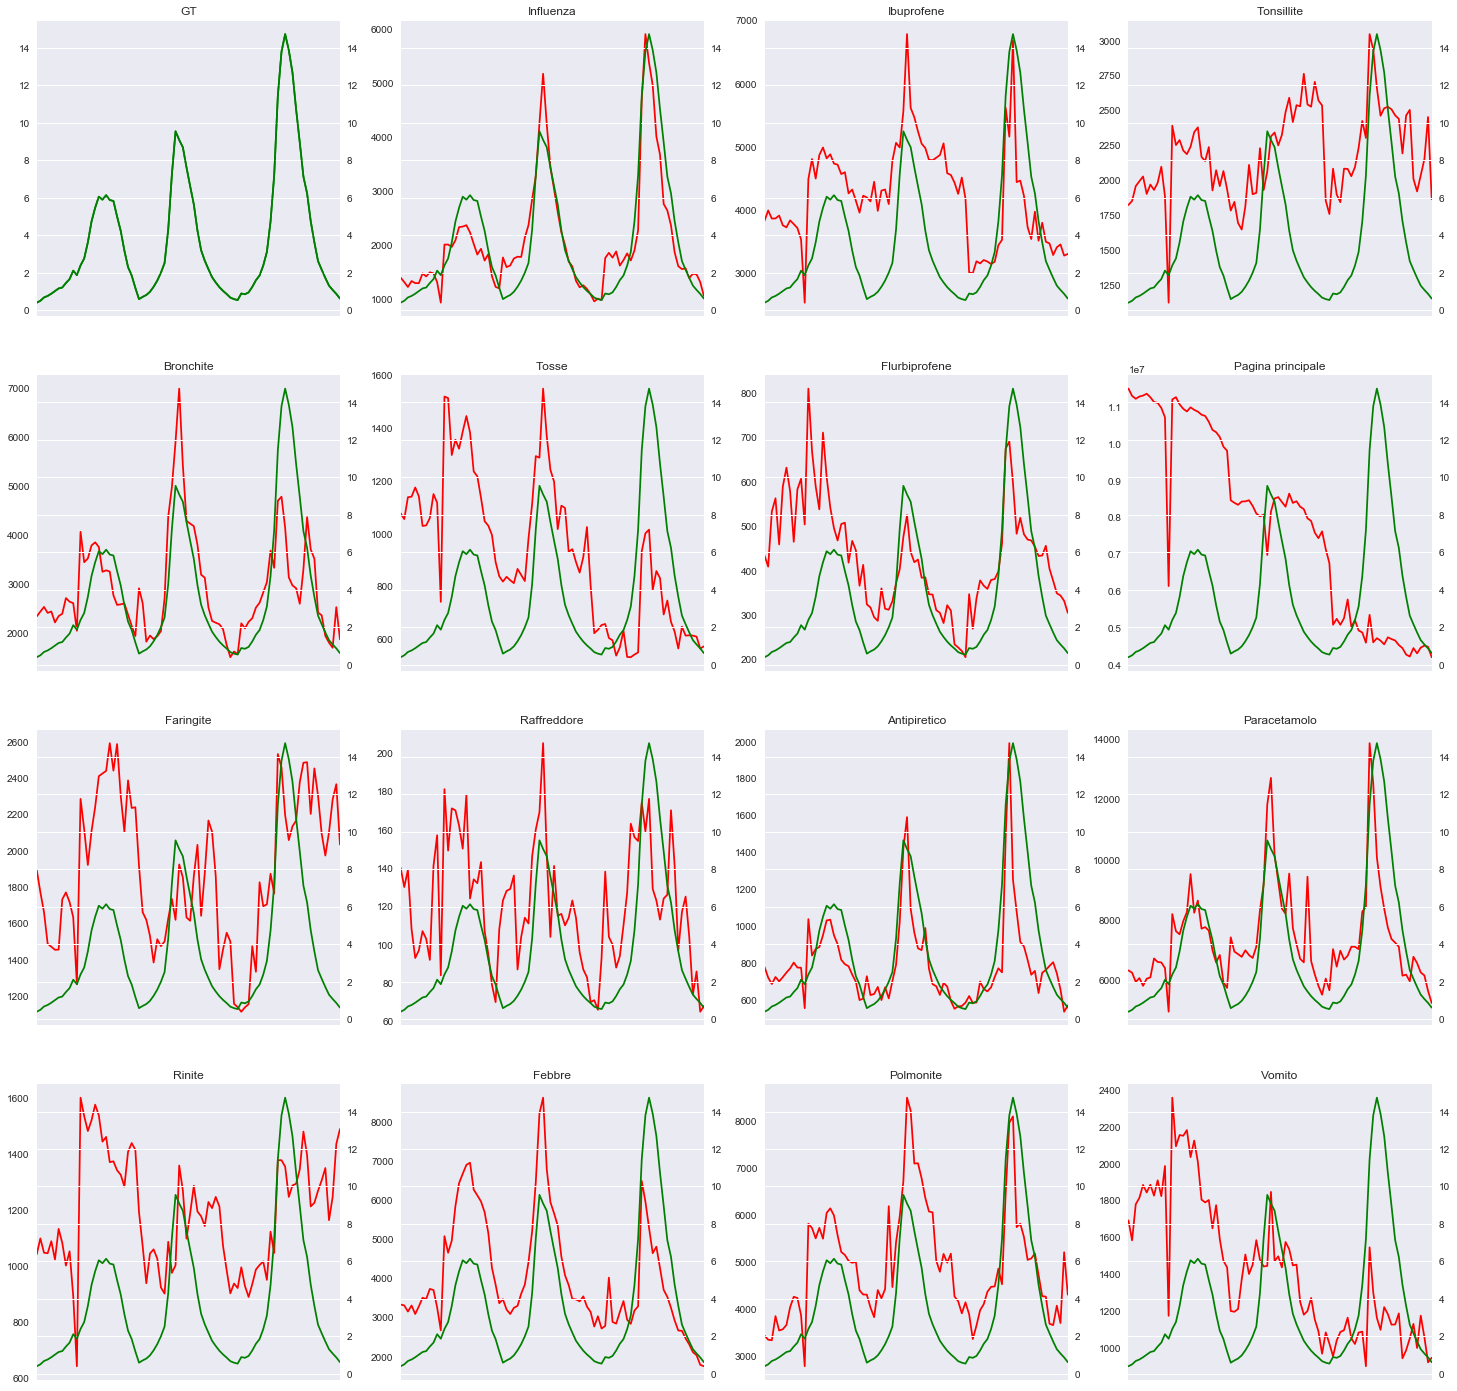

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (25,25))


data.Vomito.plot(ax=axes[3,3], color = "r", title= "Vomito")
data.Bronchite.plot(ax=axes[1,0], color = "r", title= "Bronchite")
data.Faringite.plot(ax=axes[2,0], color = "r", title= "Faringite")
data.Rinite.plot(ax=axes[3,0], color = "r", title= "Rinite")
data.Paracetamolo.plot(ax=axes[2,3], color = "r", title= "Paracetamolo")
data.Tosse.plot(ax=axes[1,1], color = "r", title= "Tosse")
data.Raffreddore.plot(ax=axes[2,1], color = "r", title= "Raffreddore")
data.Febbre.plot(ax=axes[3,1], color = "r", title= "Febbre")
data.Ibuprofene.plot(ax=axes[0,2], color = "r", title= "Ibuprofene")
data.Flurbiprofene.plot(ax=axes[1,2], color = "r", title= "Flurbiprofene")
data.Antipiretico.plot(ax=axes[2,2], color = "r", title= "Antipiretico")
data.Polmonite.plot(ax=axes[3,2], color = "r", title= "Polmonite")
data.Tonsillite.plot(ax=axes[0,3], color = "r", title= "Tonsillite")
data["Pagina principale"].plot(ax=axes[1,3], color = "r", title= "Pagina principale")
data.Influenza.plot(ax=axes[0,1], color = "r", title= "Influenza")

for i in range(4):
    for j in range(4):
        data.GT.plot(ax=axes[i,j], color = "g", secondary_y = True)
        axes[i,j].xaxis.set_visible(False)

data.GT.plot(ax=axes[0,0], color = "g", title = "GT")
        
plt.show()

As we can see, most of these words, has a similar trend to the one of the ground truth.
This does not absolutely holds, however, as far as "Pagina principale" is concerned. The terms "Vomito" , "Tosse", "Rinite" and "Tonsillite" seem to be associated with the largest discrepancy. 
In light of these observations, the model fitting phase can be addressed.  

## Part 3

This part concerns the regression analysis. Let us first briefly illustrate the salient characteristics of the chosen modelling strategy. 

#### Machine learning pipeline description



We consider two different dataset in order to make predictions:

- Dataset containing the click rates (Part 3.1) 
- Dataset containing the click rates, as well as one week lag click rates (Part 3.2) 

Furthermore, the following approaches are adopted in order to train and evalute the models: 

- Fit the models to all the data except the last week, evaluating them via cross-validation. __(1)__ 
- Use the $2018$ as a test set. Fit the model to all the previous data and evaluate them via cross-validation and out-of-sample validation.  __(2)__ 

For each combination of data, we build the following models:

- Lasso
- Ridge
- Gradient Boosting
- Elastic Net
- Bayesian Ridge

For each of the models above: 

 - The parameter space is explored by means of a grid search. A nested cross-validation approach, suitable for time series data is used, in order to evaluate different tuning parameters choices. 
 
 - The overall best model is selected based on the cross-validated mean squared error in (1) and on the test set mean squared error in (2).
 
In addition to the regularization parameters, a stepwise forward feature feature selection procedure is implemented. The large correlations among the predictors make this techique highly effective.

The results are reported as follows: 

- Cross-validated mean squared error in (1).
- Out-of-sample mean squared error and $R^2$ in (2).


In [26]:
def dataset_to_model(x, one_week_only=False):
    
    '''Create the datasets to be used in the model.
        shift = True used in point 3.2 for AutoRegressive models'''
    
    x_test = np.asarray(x.loc[2018].drop("GT",axis = 1))
    x_train = np.asarray(x.loc[[2015, 2016, 2017]].drop("GT",axis = 1))
    y_train = x.loc[[2015, 2016, 2017]][["GT"]]
    y_train = np.asarray(y_train).reshape(len(x_train), )
    y_test = np.asarray(x.loc[2018][["GT"]]).reshape(len(x_test),)

    # Rescaling
    
    min_max_scaler = preprocessing.RobustScaler()
    X_train = min_max_scaler.fit_transform(x_train)
    X_test = min_max_scaler.transform(x_test)
    X = min_max_scaler.fit_transform(x)
    
    
    if one_week_only:
        
        one_week_x_train = np.concatenate((X_train, X_test[:-1]))
        one_week_x_test = X_test[-1,]
        one_week_y_train = np.concatenate((y_train,y_test[:-1]))
        one_week_y_test = y_test[-1,]
        
        return one_week_x_train, one_week_x_test, one_week_y_train,one_week_y_test, X
    
    return X_train, X_test, y_train, y_test, X

def plot_pred(dataset, allpreds ):
    plot = dataset.copy()
    plot["Predicted_18"] = allpreds
    plot.GT.plot(label="GT", legend=True, figsize=(17,7))
    plot.Predicted_18.plot(label="Predicted", legend=True)
    plt.title("Model predictions vs influnet")
    plt.show()
    
def model_selection(models, param_grid, X_train, X_test, y_train, y_test, cv):
    
    '''Return the best model.
    Apply grid search for parameters of the models given in input.
    Apply cross validation (specifically for Time Series).'''
    
    # Set initial params
    
    min_mse = np.Inf

    # Set different parameters grid for the models

    for name, mod in models.items():
        if name in ["Lasso", "Ridge"]:
            param_search = {'alpha' : param_grid["alpha"]}

        if name == "ElasticNet": 
            param_search = { "alpha" : param_grid["alpha"],
                            "l1_ratio" : param_grid['l1_ratio']
                           }
        if name == "Gradient_Boosting":
            param_search = {'max_depth' : param_grid["max_depth"]

                           }
        if name == "Bayesian_Ridge":
            param_search = {'alpha_1' : param_grid["alpha_1"],
                            'alpha_2' : param_grid["alpha_2"]}


        if not cv:     
            my_cv = TimeSeriesSplit(n_splits = 5).split(X_train)
            gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                                param_grid=param_search, scoring = "neg_mean_squared_error", n_jobs=-1)
            a = gsearch.fit(X_train, y_train)
            pred = a.predict(X_test)

            mse = mean_squared_error(y_test, pred)

            # Save the best model 
            if mse < min_mse:
                min_mse = mse
                best_model = gsearch
                best_name = name


        else: 
            my_cv = TimeSeriesSplit(n_splits = 5).split(X_train)
            gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                                param_grid=param_search, scoring = "neg_mean_squared_error", n_jobs=-1)
            gsearch.fit(X_train, y_train)
            mse = -gsearch.best_score_

            # Save the best model
            if mse < min_mse:
                min_mse = mse
                best_model = gsearch
                best_name = name

    return [best_model, best_name, min_mse]

def feature_selection(coefs, thresh, complete_data, n_train, scaler):
    '''feature selection for Lasso and Ridge models.
    The procedure simply extracts the optimal subset of features retrieved using the printThresholdRMSE function shown in the auxiliary
    code section. As far as Lasso regression is concerned, this is equivalent to extract features associated with a coefficient different 
    from null. As regards the Ridge linear model, the procedure correspond to select only features having a coefficient larger than 0.008, 
    in absolute value.
    The output allows to fit the model using a smaller set of features, obviously changing the tuning parameter.'''
    
    #list in which each element is a tuple including the name of a feature and the absolute value of its model coefficient. 
    feats_coefs = list(zip(map(lambda x: round(x, 4), abs(coefs)), 
                     complete_data.columns))

    #sort previous list by the value of the cofficient 
    sorted_feats_coef = sorted(feats_coefs, key = lambda x: x[0], reverse = True)
    
    #extract the desired subset of features.
    chosen = [x[1] for x in sorted_feats_coef][:(thresh)]
    
    
    #create the resulting scaled training and test data sets. 
    complete_data_subset = complete_data[chosen]
    model_train = complete_data_subset[:n_train]
    model_test = complete_data_subset[n_train:]
    model_train, model_test = scaling(model_train, model_test, scaler)
    
    return (model_train, model_test, chosen)

def scaling(train, test, scaler):
    '''scale the data using the interquantile range and the median.
    Typically, standardization is carried out using the mean and the standard deviation. However, as it is 
    well-known, these satistics are drastically affected by outliers. Thus, here, a robust alternative is considered.'''

    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    return (train, test)


def plot_pred_complete(dataset, allpreds ):
    plot = dataset.copy()
    plot["Predicted_18"] = allpreds
    plot.GT.plot(label="GT", legend=True, figsize=(17,7))
    plot.Predicted_18.plot(label="Predicted", legend=True)
    plt.title("Model predictions vs influnet - Complete dataset")
    plt.show()
    
def plot_pred_test(dataset, n_train,  preds ):
    plot_test = dataset[n_train:].copy()
    plot_test["Predicted_18"] = preds
    plot_test.GT.plot(label="GT", legend=True, figsize=(17,7))
    plot_test.Predicted_18.plot(label="Predicted", legend=True)
    plt.title("Model predictions vs influnet - Focus on test dataset")
    plt.show()
    
def plot_pred_cv(dataset, n_train, allpreds): 
    plot = dataset.copy()
    plot["Predicted_18"] = allpreds
    plot.GT.plot(label="GT", legend=True, figsize=(17,7))
    plot.Predicted_18.plot(label="Predicted", legend=True)
    plt.scatter(x = n_train, y = allpreds[-1], color = "red" )
    plt.title("Model predictions vs influnet")
    plt.show()
    
def print_table(preds):
    table = [["Test set MSE", mean_squared_error(y_test, preds)],
         ["Test set- R-squared: ", r2_score(y_test, preds)]]
    display(HTML(tabulate.tabulate(table, tablefmt='html')))
    return None



In [27]:
# Model initialization 
models = {}
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["Gradient_Boosting"] = GradientBoostingRegressor(n_estimators=1000)
models["ElasticNet"] = ElasticNet()
models["Bayesian_Ridge"] = BayesianRidge()


### Part 3.1

In this subsection, no one week lag variable is considered.

__(1)__

Here, the model is fitted to the entire dataset, except for the last week. 

In [28]:
params_grid = {'alpha' : [0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2 , 2.5, 3, 3.5],
               'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1], 'max_depth' : [2, 3, 4, 5], 'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
               'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

X_train, X_test, y_train, y_test, X = dataset_to_model(data, one_week_only = True)
best_model, name, min_mse = model_selection(models, params_grid , X_train, X_test, y_train, y_test, cv = True)

print("Model chosen: " + str(name))
print("CV MSE: " + str(min_mse))

Model chosen: ElasticNet
CV MSE: 3.963273470100768


Let us carry out the forward feature selection procedure. 

In [29]:
coefs = best_model.best_estimator_.coef_
complete_data = data.drop("GT", axis = 1)
model_train, model_test, chosen = feature_selection(coefs, 7, complete_data, 83, preprocessing.RobustScaler())
print("Ther retained terms are: ", ", ".join(chosen))

Ther retained terms are:  Influenza, Febbre, Faringite, Flurbiprofene, Pagina principale, Tonsillite, Vomito


In [30]:
param_search = {'alpha' : [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5], 'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1]}
mod = ElasticNet()
my_cv = TimeSeriesSplit(n_splits = 5).split(model_train)
Gsearch = GridSearchCV(estimator=mod, scoring = "neg_mean_squared_error", cv=my_cv, param_grid=param_search, n_jobs=-1)
Gsearch.fit(model_train, y_train)

print("Cross-Validated MSE:", -Gsearch.best_score_)

Cross-Validated MSE: 3.4666161554949886


Thus, the best model is based on $7$ features and it is associated to a cross-validation mean squared error equal to approximately $3.47$, while the cross-validation mean squared error associated with the full model is about $3.96$. Broadly speaking, in what follows, feature selection always leads to a better performance. 

Let us visualize the predictions obtained in the training data as well as in the last week. 

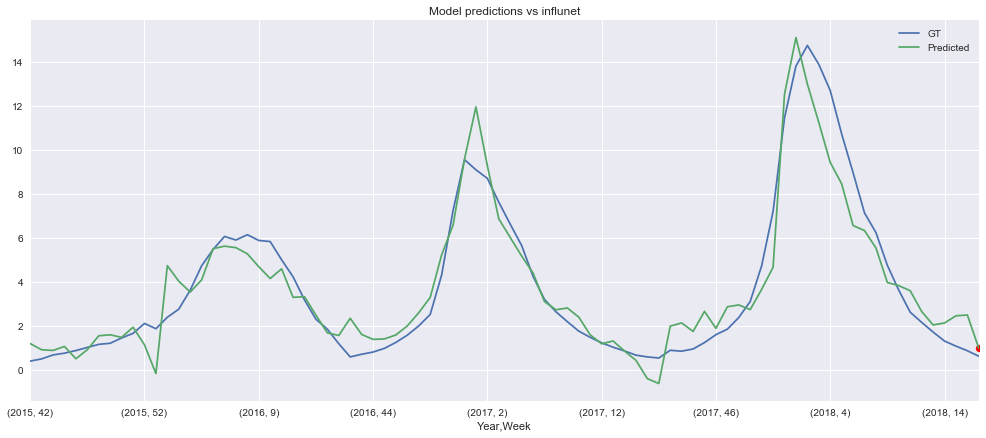

In [31]:
allpreds = list(Gsearch.best_estimator_.predict(model_train)) + list(Gsearch.best_estimator_.predict(model_test))
plot_pred_cv(data, 83, allpreds)

The predictions are reasonably accurate, but there is surely room for improvement. Here, as in the remaining part of the work, the observation not included in the training process is highlighted in red.

__(2)__

Now, split-sample analysis is considered. Specifically, the models are trained on the data corresponding to the years $2015$, $2016$ and $2017$ and evalutated in the ones associated with $2018$. 

In [32]:
params_grid = {'alpha' : [0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2 , 2.5, 3, 3.5],
               'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1], 'max_depth' : [2, 3, 4, 5], 'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
               'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

X_train, X_test, y_train, y_test, X = dataset_to_model(data, one_week_only = False)
best_model, name, min_mse = model_selection(models, params_grid , X_train, X_test, y_train, y_test, cv = False)

print("Model chosen: " + str(name))
print("Test set MSE: " + str(min_mse))

Model chosen: Ridge
Test set MSE: 9.333898035809915


Again, a forward feature selection method is exploited. 

In [33]:
coefs = best_model.best_estimator_.coef_
complete_data = data.drop("GT", axis = 1)
model_train, model_test, chosen = feature_selection(coefs, 3, complete_data, 67, preprocessing.RobustScaler())
print("The retained terms are: ", ", ".join(chosen))

The retained terms are:  Febbre, Faringite, Influenza


In [34]:
param_search = {'alpha' : [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5]}
mod = Ridge()
my_cv = TimeSeriesSplit(n_splits = 5).split(model_train)
Gsearch = GridSearchCV(estimator=mod, scoring = "neg_mean_squared_error", cv=my_cv, param_grid=param_search, n_jobs=-1)
Gsearch.fit(model_train, y_train)

preds = Gsearch.best_estimator_.predict(model_test)

Let us take a look at the test set error metrics. 

In [35]:
print_table(preds)

Test set MSE,6.24007
Test set- R-squared:,0.75227


Keeping only three terms lead to a parsimonious model outperforming the one based on the complete collection of terms.  

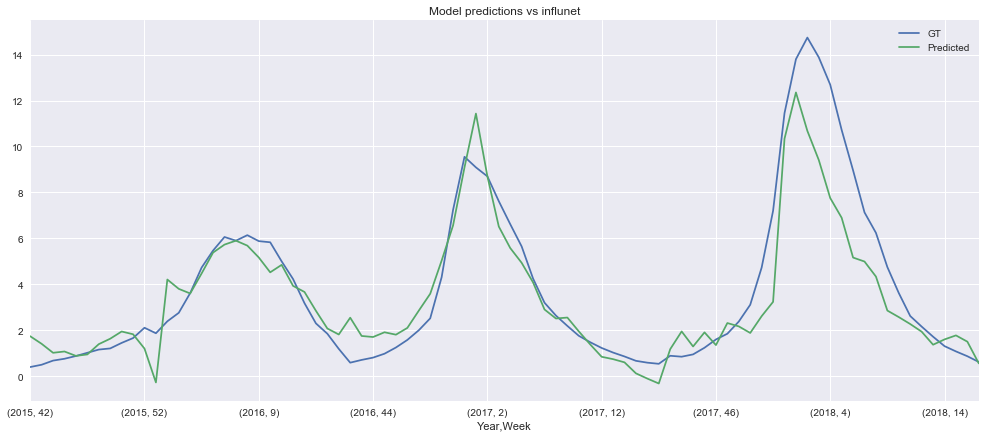

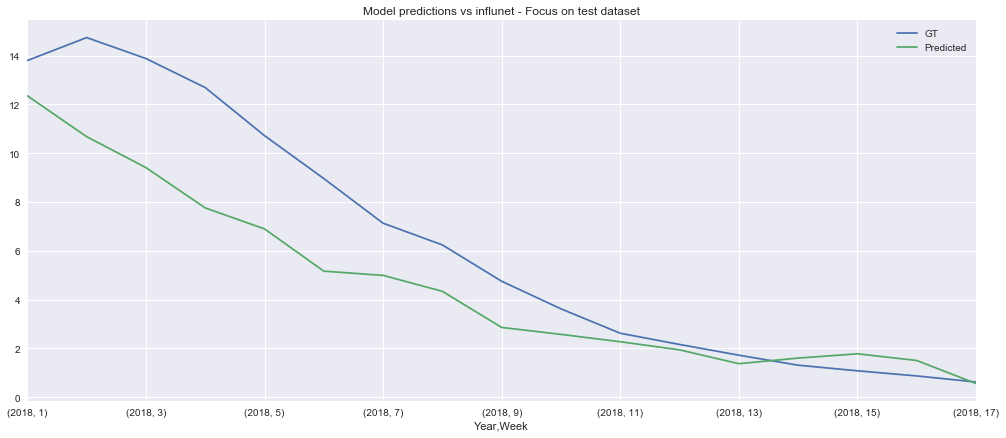

In [36]:
allpreds = list(Gsearch.best_estimator_.predict(model_train)) + list(Gsearch.best_estimator_.predict(model_test)) 
plot_pred(data, allpreds)
plot_pred_test(data, 67,  preds)

# Part 3.2

So far, the temporal dependence of the data has not been thoroughly considered.  
As usual, when dealing with time series data, it is useful to consider lags of the dependent variable as well as independent ones. Thus, let us investigate whether more accurate predictions can be obtained after lagged variables are included in the model. In what follows,  the same strategy as before is followed.

In [37]:
def get_shift(col):
    flu_serie = pd.Series(np.asarray(data[[col]]).reshape(84,))
    serie = flu_serie.shift(1)
    return serie

def create_shift_dataset(data, cols_list):
    flu_AR1 = data.copy()
    cols_list.append('GT')
    for col in cols_list:
        flu_AR1[col+str(1)] = np.asarray(get_shift(col))
    flu_AR1 = flu_AR1.drop(flu_AR1.index[0])
    return flu_AR1

In [38]:
data_lag = create_shift_dataset(data, cols_list = list(data.columns))

Many of the introduced variables are relevant. In particulary, the ground truth ILI level measured at the previous week seems to be the most valuable. This becomes clear when looking at the plot below. 

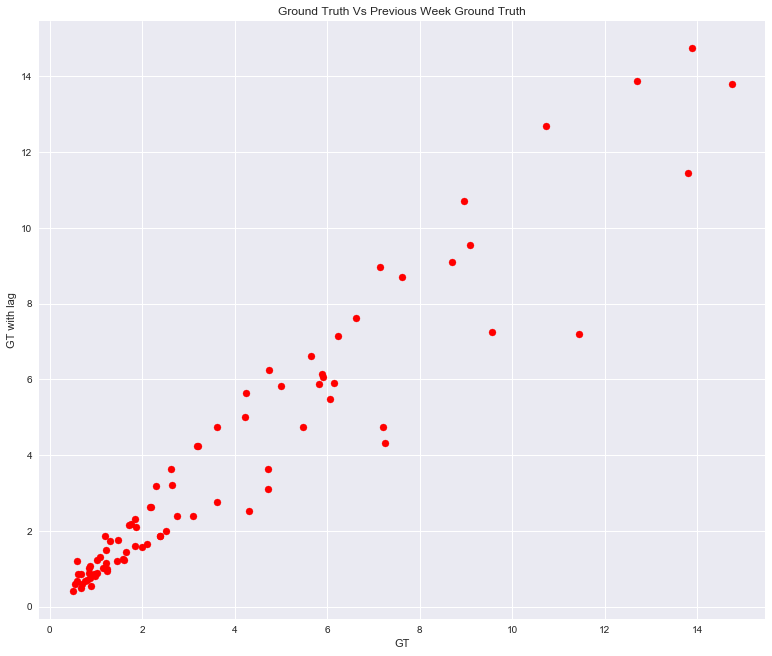

In [39]:
plt.scatter(data_lag["GT"], data_lag["GT1"], color = "red")
plt.title("Ground Truth Vs Previous Week Ground Truth")
plt.xlabel("GT")
plt.ylabel("GT with lag")
plt.show()

In [40]:
params_grid = {'alpha' : [0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2 , 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6,8, 10],
               'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1], 'max_depth' : [2, 3, 4, 5, 8, 10], 'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
               'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

X_train, X_test, y_train, y_test, X = dataset_to_model(data_lag, one_week_only = True)
best_model, name, min_mse = model_selection(models, params_grid , X_train, X_test, y_train, y_test, cv = True)

print("Model chosen: " + str(name))
print("Cross-Validated MSE: " + str(min_mse))

Model chosen: ElasticNet
Cross-Validated MSE: 2.7113507455367722


As usual, let us consider a less complex model obtained by a forward selection procedure. 

In [41]:
coefs = best_model.best_estimator_.coef_
complete_data = data_lag.drop("GT", axis = 1)
model_train, model_test, chosen = feature_selection(coefs, 3, complete_data, 82, preprocessing.RobustScaler())
print("The retained terms are : ", " , ".join(chosen))

The retained terms are :  GT1 , Influenza , Flurbiprofene


In [42]:
param_search = {'alpha' : [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5], 'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1]}
mod = ElasticNet()
my_cv = TimeSeriesSplit(n_splits = 5).split(model_train)
Gsearch = GridSearchCV(estimator=mod, scoring = "neg_mean_squared_error", cv=my_cv, param_grid=param_search, n_jobs=-1)
Gsearch.fit(model_train, y_train)
print("Cross-Validated MSE:", -Gsearch.best_score_)

Cross-Validated MSE: 0.6667886799395623


Again, the variable selection algorithm yields a substantial reduction in the cross-validation mean squared error.

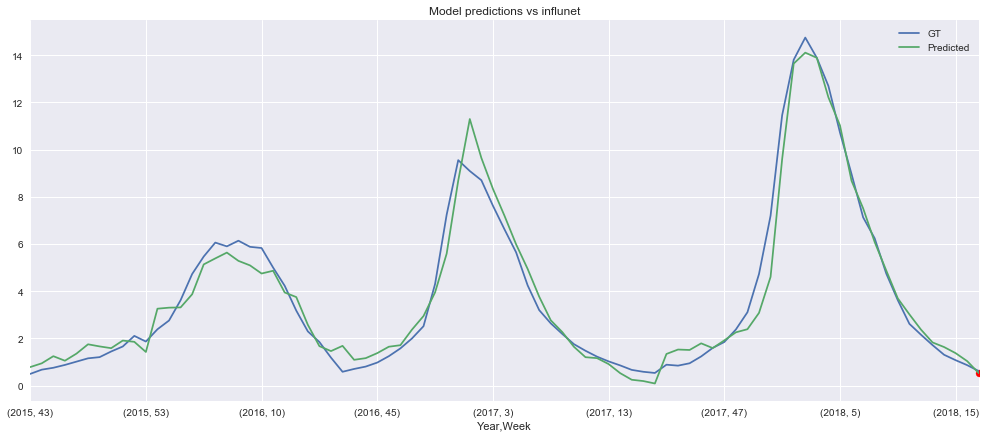

In [43]:
allpreds = list(Gsearch.best_estimator_.predict(model_train)) + list(Gsearch.best_estimator_.predict(model_test))
plot_pred_cv(data_lag, 82, allpreds)

From the plot above, it can be easily observed that after the introduction of one week lag features, prediction can be obtained, which follows much more closely the ground truth trend. A crucial role is played by the lagged influnet time series, which shows the largest coefficient of the elastic net model and thus it is identified as the most important feature. 

__(2)__

Let us address the split-sample analysis which involves, unlike above, one week lag variables. 

In [44]:
params_grid = {'alpha' : [0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1, 1.1, 1.5, 2, 2.5, 3, 3.5],
               'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1], 'max_depth' : [2, 3, 4, 5], 'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
               'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

X_train, X_test, y_train, y_test, X = dataset_to_model(data_lag, one_week_only = False)
best_model, name, min_mse = model_selection(models, params_grid, X_train, X_test, y_train, y_test, cv = False)

print("Model chosen: " + str(name))
print("Test Set MSE: " + str(min_mse))

Model chosen: Lasso
Test Set MSE: 1.005649548413981


At this point, the usual feature selection method is exploited. This is the last fitted model. Broadly speaking, it can be regarded as the proposed one, in opposition to the one presented in [[1]](#Reference). Hence, instead of a simple forward feature selection algorithm, which is very likely to converge to a local minumum, a more exhaustive search is performed, evaluating the different models for all the combinations of the best predictors identified by the Lasso model coefficients.

In [45]:
coefs = best_model.best_estimator_.coef_
complete_data = data_lag[["GT1" , "Febbre" ,"Influenza" , "Flurbiprofene"]]
model_train, model_test, chosen = feature_selection(coefs, 4,  complete_data, 66 , preprocessing.RobustScaler())
print("The retained terms are : ", " , ".join(chosen))

The retained terms are :  Flurbiprofene , GT1 , Febbre , Influenza


In [46]:
param_grid = {'alpha': [1e-9, 1e-8, 1e-6, 1e-4, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1],
              'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1],
              'max_depth' :   [2, 3, 4, 5, 7], 'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6], 'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
                   }

best_model, name, min_mse = model_selection(models, param_grid, model_train, model_test, y_train, y_test, cv = False)
print("Model chosen: " + str(name))

Model chosen: Bayesian_Ridge


In [47]:
preds = best_model.best_estimator_.predict(model_test) 
print_table(preds)

Test set MSE,0.103513
Test set- R-squared:,0.995891


The result looks promising. As a matter of fact, the out-of-sample $R^2$ is extremely close to its upper bound.  

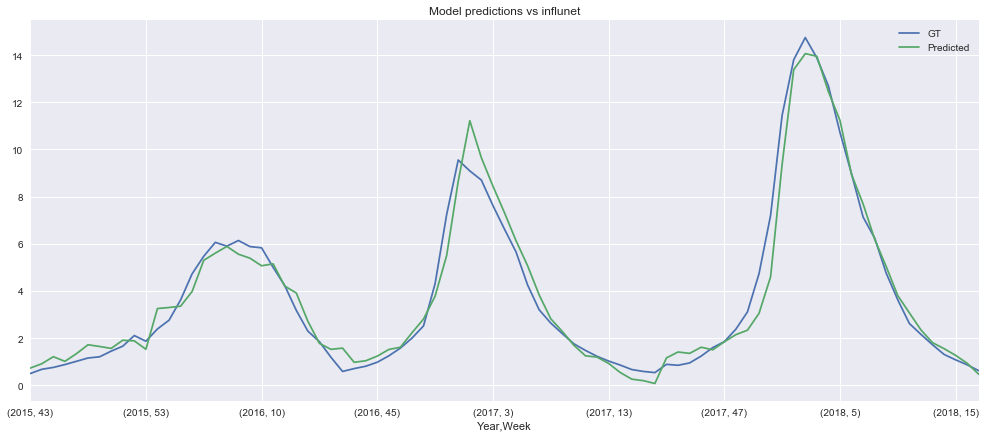

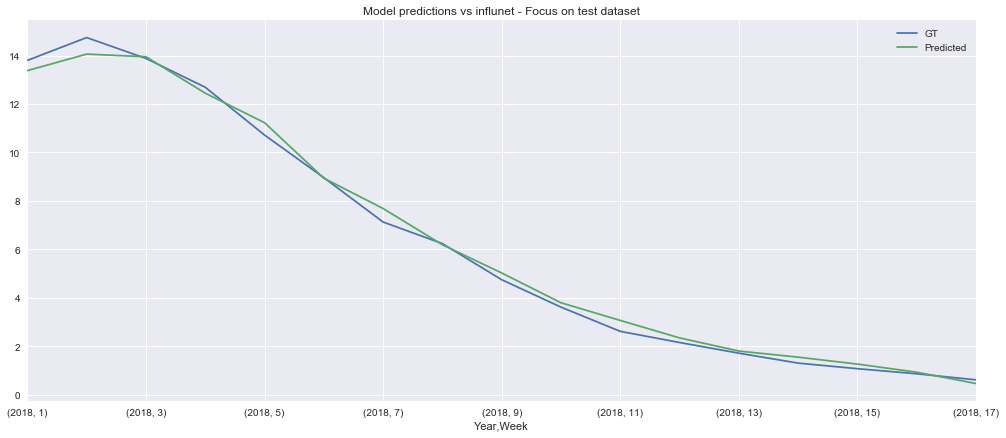

In [48]:
allpreds = list(best_model.best_estimator_.predict(model_train)) + list(best_model.best_estimator_.predict(model_test)) 
plot_pred(data_lag, allpreds)
plot_pred_test(data_lag, 66,  preds)

The test set predictions are noticeably accurate. In each week, the discrepancy between model predictions and ground truth is very low. 

In paper [[1]](#Reference), furthermore, McIver and Brownstein assert that, based on a split-sample analysis, a Pearson correlation coefficient beween predictions and ground truth of about 0.985 is found. As far as this study is concerned, an analogous information is given below.  

In [49]:
corr = [pearsonr(preds , y_test )[0], spearmanr(preds , y_test)[0]]
print("Pearson correlation " + str(corr[0]) + "\n" + "Spearman correlation " + str(corr[1]))

Pearson correlation 0.9984068638542476
Spearman correlation 1.0


Similarly, in the entire dataset, the results are as follows.

In [50]:
corr = [pearsonr( allpreds , (list(y_train) + list(y_test)) )[0], spearmanr( allpreds , (list(y_train) + list(y_test)))[0]]
print("Pearson correlation " + str(corr[0]) + "\n" + "Spearman correlation " + str(corr[1]))

Pearson correlation 0.9820099454232675
Spearman correlation 0.9746961652826259


In [1](#Reference), the Pearson correlation associated with predictions and ground truth in the overall dataset is reported to be 0.938.

#### Poisson regression model

Nevertheless, the above comparison is not enough. Thus, a model analogous to the one proposed by McIver and Brownstein is developed. This is a regularized generalized linear model in which the Poisson distribution is postulated for the dependent variable and a natual logarithm (canonical) link function is used. 
This is a common choice when dealing with count and rate data.

In [51]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from C:\Users\tomma\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tomma\AppData\Local\Temp\tmpae5kmmu0
  JVM stdout: C:\Users\tomma\AppData\Local\Temp\tmpae5kmmu0\h2o_tomma_started_from_python.out
  JVM stderr: C:\Users\tomma\AppData\Local\Temp\tmpae5kmmu0\h2o_tomma_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_tomma_zhauj0
H2O cluster total nodes:,1
H2O cluster free memory:,1.747 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [52]:
def fitPoisson(dataset, n_train, alpha, cv ):
    
    '''Fit the Poisson model by doing (if cv=True) cross validation and grid search procedures.
        Return the predictions for both train and test and (if cv=True) the best model.
        - cv = True: test set of one week;
        - cv = False: test set of 17 weeks for an year.'''
    
    y_index = 15
    x_indeces = [x for x in range(len(dataset.columns)) if x != y_index]
    x = list(dataset.columns[x_indeces])
    y = dataset.columns[y_index]
    train_poiss = dataset[:n_train].copy()
    test_poiss = dataset[n_train:].copy()
    test_poiss = test_poiss.drop("GT", axis = 1)
    
    if not cv: 
        poiss_mod = H2OGeneralizedLinearEstimator(family= "poisson", nfolds = 10, alpha = alpha, lambda_search = True,standardize = True, link = "log")
        poiss_mod.train(x, y, training_frame= h2o.H2OFrame(train_poiss))
        y_pred_test = poiss_mod.predict(h2o.H2OFrame(test_poiss)).as_data_frame().values[:]
        y_pred_train = poiss_mod.predict(h2o.H2OFrame(train_poiss)).as_data_frame().values[:]
        return [y_pred_test, y_pred_train]
   
    else: 
        # Perform grid search 
        alpha_opts = [0.0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6,0.65, 0.7,0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
        hyper_parameters = {"alpha" : alpha_opts}
        poiss_mod = H2OGeneralizedLinearEstimator(family= "poisson", nfolds = 10, lambda_search = True, standardize = True, seed = 1, keep_cross_validation_fold_assignment = True, link = "log")
        grid = H2OGridSearch(poiss_mod, hyper_params=hyper_parameters)  
        grid.train(x, y, training_frame= h2o.H2OFrame(train_poiss), nfolds = 10, keep_cross_validation_fold_assignment = True, seed = 1 )
        got_grid = grid.get_grid()
        
        # Extract best model 
        best_mod = got_grid.models[0]
        
        # Obtain predictions 
        y_pred_train = best_mod.predict(h2o.H2OFrame(train_poiss)).as_data_frame().values[:]
        y_pred_test = best_mod.predict(h2o.H2OFrame(test_poiss)).as_data_frame().values[:]        
        return [y_pred_train, y_pred_test, best_mod.mse(xval = True)]
    
def average_predictions(preds, w1, preds_poiss, w2): 
    
    '''Return the weighted average of the two predictions chosen.'''
    
    ensemble_pred = [(w1 * preds[i] + w2 * preds_poiss[i]) for i in range(len(preds))]
    return ensemble_pred

__(1)__ 

At first, in agreeement with the approach adopted before, the model is fitted on the entire dataset, save last week. Clearly, one week lag variables are included. 

In [53]:
train_preds, test_preds, mse = fitPoisson(data_lag, 82, alpha = None, cv = True  )
print("\n" + "Cross-Validation MSE:", mse)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%

Cross-Validation MSE: 1.1338820466665207


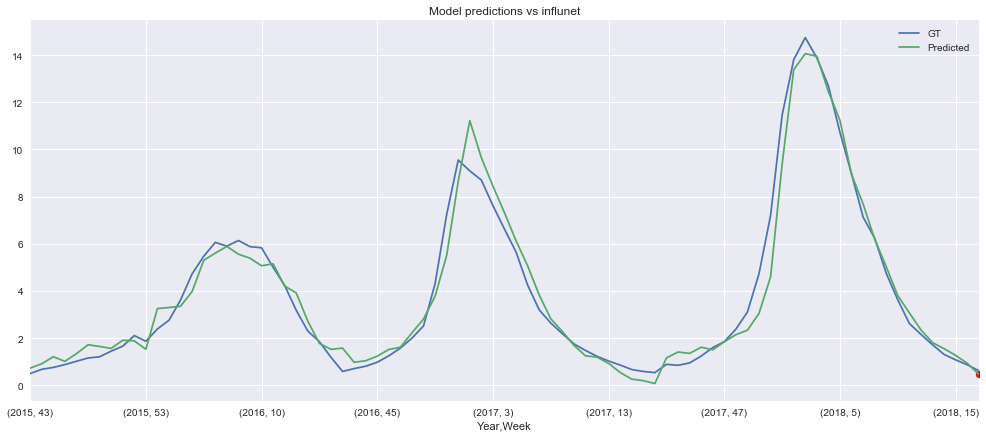

In [54]:
allpreds_poiss = [x[0] for x in list(train_preds) + list(test_preds)]
plot_pred_cv(data_lag, 82, allpreds)

The predictions appears to be not as accurate as the ones obtained before in the same scenario. As a matter of fact, the cross-validation mean squared error is increased.

__(2)__

Now, the scenario in which the 2018 is treated as test set is considered. 

In [55]:
test_preds_poiss, train_preds = fitPoisson(data_lag, n_train = 66, alpha = 0.8, cv = False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [56]:
print_table(test_preds_poiss)

Test set MSE,1.08219
Test set- R-squared:,0.957037


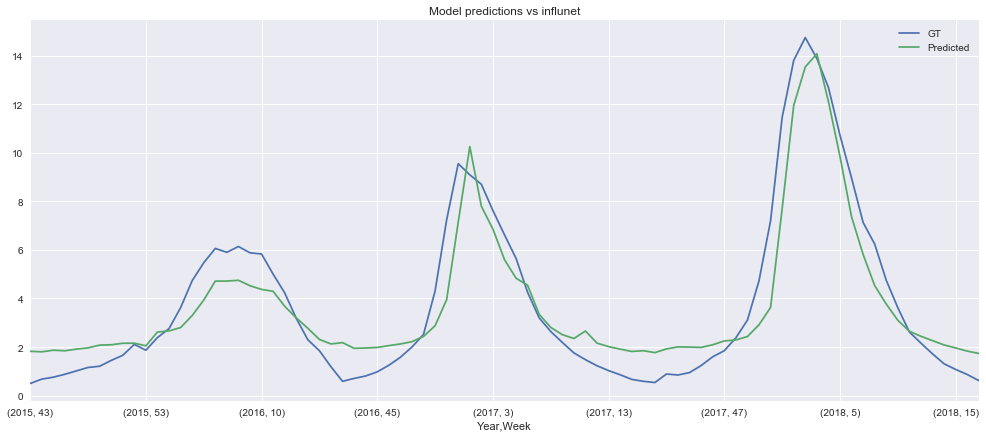

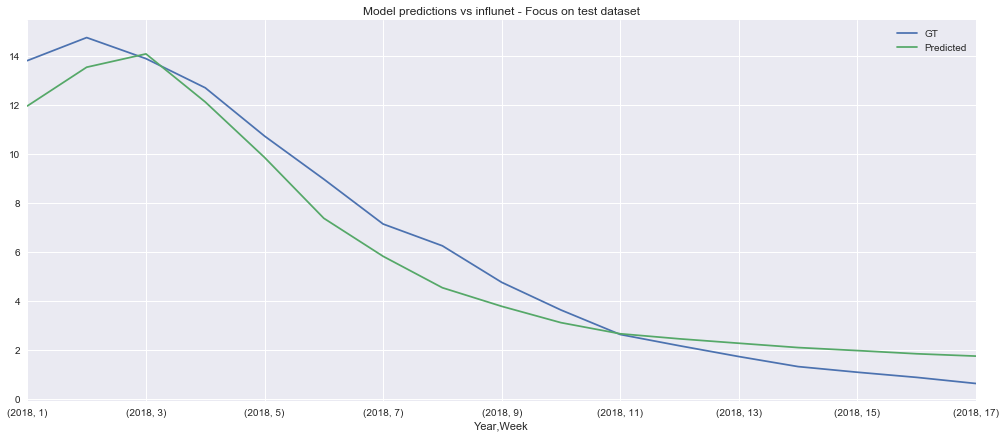

In [57]:
allpreds = [x[0] for x in list(train_preds) + list(test_preds_poiss)]
plot_pred(data_lag, allpreds)
test_preds = [x[0] for x in list(test_preds_poiss)]
plot_pred_test(data_lag, 66,  test_preds_poiss)

In the test set, the prediction quality is far from the ones reported in the previous sections. 

The Poisson regression model yielding the best performance in the test set is obtained by setting the parameter controlling the distribution between $l1$ and $l2$-norm penalties to $0.8$, which strongly favors the former. Indeed, a value of $1$ would correspond to Lasso regression. 

It could however, be possible to use the fitted Poisson regression model in order to obtain ensemble predictions. In plain words, the predictions obtained in the previous section can be combined using a weighted average with the ones produced by the regularized Poisson generalized linear model. Let us focus on the sample -split analysis, in which the 2018 weeks are regarded as test set and the previous observations as training set. 

In [58]:
newpreds = average_predictions(preds, 0.9, test_preds_poiss, 0.1)
print_table(newpreds)

Test set MSE,0.102027
Test set- R-squared:,0.99595


The mean squared error corresponding to the averaged predictions with optimal weights is slightly smaller than the one obtained before. More precisely, it corresponds to about its $98.5\%$.

## Discussion

The study results suggest that using Wikipedia page views data, remarkably accurate ILI level predictions can be obtained. Several Wikipedia article page views ehibit a strong correlation with the Influnet ground truth data. The most correlated word turns out to be "Influenza". Moreover, it is shown that including lagged variables, provides a considerable improvement. In particular, the fitted models suggest that the preceeding week ground truth is the most relevant. Also feature selection, which leads to define very parsimonious models, yields a performance improvement. The regularized Poisson generalized linear model, exploited in [[1]](#Reference), does not appear to provide the optimal performance. However, it is shown, than combining the optimal model predictions with the ones generated by the Poisson regression model it is possible to gain an improvement in the test set error metrics. Certainly, the comparison between our model and the ones described in [[1]](#Reference) is not straightforward, since they are based on different data. 
The study findings might be valuable in order to provide valuable health related insight and guide policy-making. 
For futher work, it might be interesting to train the models after excluding high-volume time sections and compare it with the model fitted on the entire dataset, in order to investigate the estimating ability of model in the presence of higher-than-normal levels of ILI or Wikipedia page views. This is also carried out in [[1]](#Reference). Furthermore, it could be appropriate to explicitly account for the effect of seasonalities. 

## Reference


[1] D.J. McIver & J. S. Brownstein (2014), "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time", PLoS Comput Biol 10(4): e1003581 http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003581